In [1]:
%matplotlib inline

In [3]:
%load_ext line_profiler

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf

In [6]:
from scipy.stats import norm

In [7]:
from timeit import default_timer as timer

### TensorFlow Graph vizualization

* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
* http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
* http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [8]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Kalman Filter with TensorFlow

In [9]:
class DynamicSystem(object):

    def __init__(self, x = None, F = None, H = None, sigma = 1.0):
        self.x = x
        self.F = F
        self.H = H
        self.sigma = sigma

    def simulate(self, n):
        self.y =[]
        self.track =[]
        x = self.x
        for i in range (n):
            x = np.dot (self.F, x)
            self.y.append (np.dot (self.H, x))
            self.track.append (x)
        return np.array (self.y)

In [10]:
class TFKalmanFilter(object):

    def __init__(self, state_dim, obs_dim, F, H, summary = False):

        self.state_dim = state_dim
        self.obs_dim = obs_dim

        self.X0 = np.zeros(self.state_dim)
        self.P0 = np.eye(self.state_dim)

        self.summary = summary
        self._F = F
        self._H = H
        self._create_computational_graph()


    def _create_computational_graph(self):
        self._graph = tf.Graph()
        with self._graph.as_default():
            self.ym = tf.placeholder(dtype=tf.float32, shape=[self.obs_dim], name='ym')
            with tf.name_scope('Model_Definition'):
                self.F = tf.constant(self._F, dtype=tf.float32, name='F')
                self.H = tf.constant(self._H, dtype=tf.float32, name='H')

                self.R = tf.constant(np.eye(self.obs_dim), dtype=tf.float32, name='R')
                self.I = tf.constant(np.eye(self.state_dim), dtype=tf.float32, name='I')
            # initial state
            with tf.name_scope('State_Initialization'):
                self.X = tf.Variable(tf.convert_to_tensor(self.X0, dtype=tf.float32), dtype=tf.float32, name='X')
                self.P = tf.Variable(tf.convert_to_tensor(self.P0, dtype=tf.float32), dtype=tf.float32, name='P')
            # predict new state
            with tf.name_scope('State_Prediction'):
                Xf = tf.reduce_sum(tf.multiply(self.F, self.X), axis=1, name='Xf')
                Pf = tf.matmul(self.F, tf.matmul(self.P, tf.transpose(self.F)), name='Pf')
            # predict observation and get renewal
            with tf.name_scope('Observation_Prediction'):
                self.yf = tf.reduce_sum(tf.multiply(self.H, Xf), axis=1, name='yf')
                mu = tf.subtract(self.ym, self.yf, name='mu')
            # compute Kalman gain 
            with tf.name_scope('Kalman_Gain'):
                S = tf.matrix_inverse(tf.add(tf.matmul(self.H, tf.matmul(Pf, tf.transpose(self.H))), self.R), name='S')
                K = tf.matmul(tf.matmul(Pf, tf.transpose(self.H)), S, name='K')
            # correct state
            with tf.name_scope('State_Correction'):
                Xup = tf.add(Xf, tf.reduce_sum(tf.multiply(K, mu), axis=1), name='Xup')
                Pup = tf.matmul(tf.subtract(self.I, tf.matmul(K, self.H)), Pf, name='Pup')
            # assign new state
            with tf.name_scope('State_Update'):
                self.X = tf.assign(self.X, Xup)
                self.P = tf.assign(self.P, Pup)
            if self.summary:
                self.X_hist = tf.summary.histogram('X', self.X)
                self.P_hist = tf.summary.histogram('P', self.P)

    def initialize_state(self, X, P):
        reset = False
        if X is not None:
            self.X0 = X
            reset = True
        if P is not None:
            self.P0 = P
            reset = True
        if reset:
            tf.reset_default_graph()
            self._create_computational_graph()


    def fit(self, y, X = None, P = None, summary = False):

        self.initialize_state(X, P)

        self.y_fit = []
        self.X_trace = []
        self.P_trace = []

        with tf.Session(graph=self._graph) as sess:
            if self.summary:
                # Merge all the summaries and write them out to logs
                merged = tf.summary.merge_all()
                writer = tf.summary.FileWriter("logs", self._graph)

            sess.run(tf.global_variables_initializer())

            for i, y_ in enumerate(y):
                if self.summary:
                    X_, P_, yf_, summary_str = sess.run([self.X, self.P, self.yf, merged], feed_dict={self.ym: y_})
                else:
                    X_, P_, yf_ = sess.run([self.X, self.P, self.yf], feed_dict={self.ym: y_})
                self.y_fit.append(yf_)
                self.X_trace.append(X_)
                self.P_trace.append(P_)
                if self.summary:
                    writer.add_summary(summary_str, i)
            if self.summary:
                writer.close()
        self.y_fit = np.array(self.y_fit)

        return self.y_fit

In [11]:
F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], dtype='float32')
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype='float32')
X = np.array([0.5, 0.5, 0.2, 0.3])
ds = DynamicSystem(X, F, H)
n = 100
Y = ds.simulate(n) + norm.rvs(loc=0, scale=5., size=n * 2).reshape(n, 2)
Y = np.asarray(Y, dtype='float32')
R = np.eye(2, dtype='float32') * .1
I = np.eye(4, dtype='float32')
X0 = np.zeros(4, dtype='float32')
P0 = np.eye(4, dtype='float32') * .1

In [12]:
kf = TFKalmanFilter(4, 2, F, H)
kf.initialize_state(X0, P0)
y_fit = kf.fit(Y)

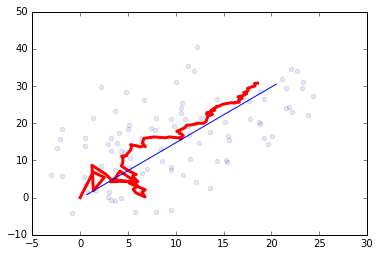

In [13]:
y_true = ds.simulate(n)
plt.scatter(Y.T[0], Y.T[1], alpha=0.1)
plt.plot(y_fit.T[0], y_fit.T[1], lw=3, color='red')
plt.plot(y_true.T[0], y_true.T[1]);

### Tensor Board

In [14]:
strip_def = strip_consts(kf._graph.as_graph_def())
show_graph(strip_def)

### Profiler

In [15]:
%lprun -s -f kf.fit -T lp_results.txt kf.fit(Y)
%cat lp_results.txt


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 0.104894 s
File: <ipython-input-10-33decfaee161>
Function: fit at line 68

Line #      Hits         Time  Per Hit   % Time  Line Contents
    68                                               def fit(self, y, X = None, P = None, summary = False):
    69                                           
    70         1            8      8.0      0.0          self.initialize_state(X, P)
    71                                           
    72         1            2      2.0      0.0          self.y_fit = []
    73         1           81     81.0      0.1          self.X_trace = []
    74         1           52     52.0      0.0          self.P_trace = []
    75                                           
    76         1          783    783.0      0.7          with tf.Session(graph=self._graph) as sess:
    77         1            2      2.0      0.0              if self.summary:
    78                  